# Model Scores Analysis

This notebook provides tools to analyze the scores generated by the trading model. The analysis includes:

## Features
- Score distribution visualization
- Top 20 scores bar chart
- Summary statistics
- Detailed score breakdown

## Usage
```python
# Analyze scores for a specific date
scores_df = analyze_model_scores('model_outputs/technical/2025-06-03')

# View top 10 scores
print(scores_df.head(10))

# Get tickers with scores above a threshold
high_scores = scores_df[scores_df['score'] > 7.0]
print(f"Tickers with scores > 7.0: {len(high_scores)}")
print(high_scores[['ticker', 'score']])
```

## Output
The analysis provides:
1. A histogram showing the distribution of scores
2. A bar chart of the top 20 scores
3. Summary statistics including mean, median, min, and max scores
4. A DataFrame with all scores for further analysis

## Additional Analysis
You can perform additional analysis on the returned DataFrame:
```python
# Score quartiles
quartiles = scores_df['score'].quantile([0.25, 0.5, 0.75])
print("Score quartiles:")
print(quartiles)

# Score ranges
score_ranges = pd.cut(scores_df['score'], 
                     bins=[0, 5, 6, 7, 8, 10],
                     labels=['0-5', '5-6', '6-7', '7-8', '8-10'])
print("\nNumber of tickers in each score range:")
print(score_ranges.value_counts().sort_index())
```
```

This code provides:
1. A function to analyze scores from a model outputs directory
2. Visualizations using plotly (histogram and bar chart)
3. Summary statistics
4. A markdown cell with usage examples and additional analysis options

To use it:
1. Copy both cells into your notebook
2. Run the code cell to define the function
3. Use the function with your model outputs directory
4. Follow the examples in the markdown cell for additional analysis

Would you like me to:
1. Add more visualization options?
2. Add analysis of the technical details?
3. Add comparison between different dates?
4. Add export functionality for the analysis?

In [10]:
# Code cell
import pandas as pd
import numpy as np
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

def get_scalar(value):
    """Convert numpy array to scalar value."""
    if isinstance(value, np.ndarray):
        return float(value.item())
    return value

def analyze_model_scores(model_outputs_dir: str):
    """
    Analyze scores from model outputs directory.
    
    Args:
        model_outputs_dir: Path to model outputs directory (e.g., 'model_outputs/technical/2025-06-03')
    """
    # Convert to Path object
    outputs_dir = Path(model_outputs_dir)
    
    # Get date from directory name
    date = outputs_dir.name
    
    # Collect all scores
    scores = []
    for parquet_file in outputs_dir.glob("*.parquet"):
        try:
            df = pd.read_parquet(parquet_file)
            if date in df['date'].values:
                row = df[df['date'] == date].iloc[0]
                # Extract score and details
                score = get_scalar(row['score'])
                details = {k: get_scalar(v) for k, v in row['details'].items()}
                scores.append({
                    'ticker': parquet_file.stem,
                    'score': score,
                    **details  # Flatten the details dictionary
                })
        except Exception as e:
            print(f"Error processing {parquet_file.stem}: {e}")
    
    # Convert to DataFrame
    scores_df = pd.DataFrame(scores)
    
    if scores_df.empty:
        print(f"No scores found for {date}")
        return None
    
    # Sort by score
    scores_df = scores_df.sort_values('score', ascending=False)
    
    # Print summary statistics
    print(f"\nScore Summary for {date}:")
    print(f"Total tickers: {len(scores_df)}")
    print(f"Average score: {scores_df['score'].mean():.2f}")
    print(f"Median score: {scores_df['score'].median():.2f}")
    print(f"Min score: {scores_df['score'].min():.2f}")
    print(f"Max score: {scores_df['score'].max():.2f}")
    
    # Create score distribution plot
    fig = px.histogram(scores_df, x='score', 
                      title=f'Score Distribution for {date}',
                      nbins=20)
    fig.update_layout(
        xaxis_title="Score",
        yaxis_title="Number of Tickers",
        showlegend=False
    )
    fig.show()
    
    # Create top 20 scores bar chart
    top_20 = scores_df.head(20)
    fig = px.bar(top_20, x='ticker', y='score',
                title=f'Top 20 Scores for {date}')
    fig.update_layout(
        xaxis_title="Ticker",
        yaxis_title="Score",
        xaxis_tickangle=-45
    )
    fig.show()
    
    # Create score component breakdown for top 10
    if not scores_df.empty:
        top_10 = scores_df.head(10)
        component_cols = ['bollinger', 'macd', 'moving_averages', 'rsi', 'volume']
        
        # Melt the DataFrame for plotting
        details_melted = pd.melt(top_10, 
                                id_vars=['ticker'],
                                value_vars=component_cols,
                                var_name='component',
                                value_name='score')
        
        # Create component breakdown plot
        fig = px.bar(details_melted, 
                    x='ticker', 
                    y='score',
                    color='component',
                    title=f'Score Component Breakdown for Top 10 Tickers',
                    barmode='group')
        fig.update_layout(
            xaxis_title="Ticker",
            yaxis_title="Score",
            xaxis_tickangle=-45
        )
        fig.show()
    
    return scores_df

# Example usage:
# scores_df = analyze_model_scores('model_outputs/technical/2025-06-03')


Score Summary for 2025-06-03:
Total tickers: 503
Average score: 5.05
Median score: 5.45
Min score: 1.82
Max score: 6.36


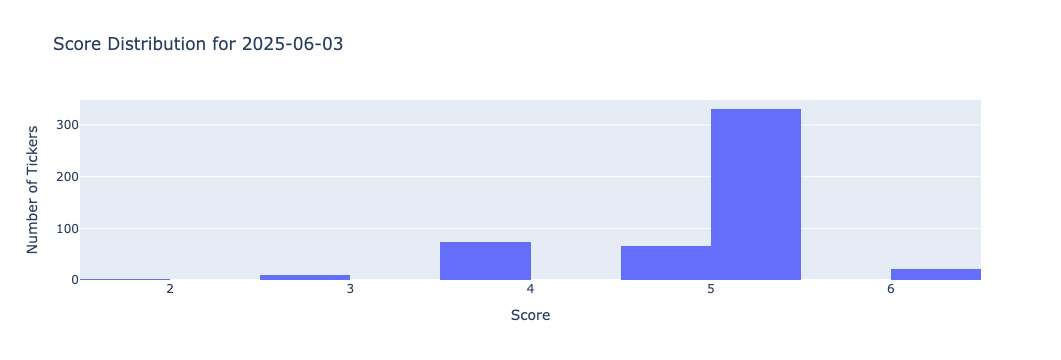

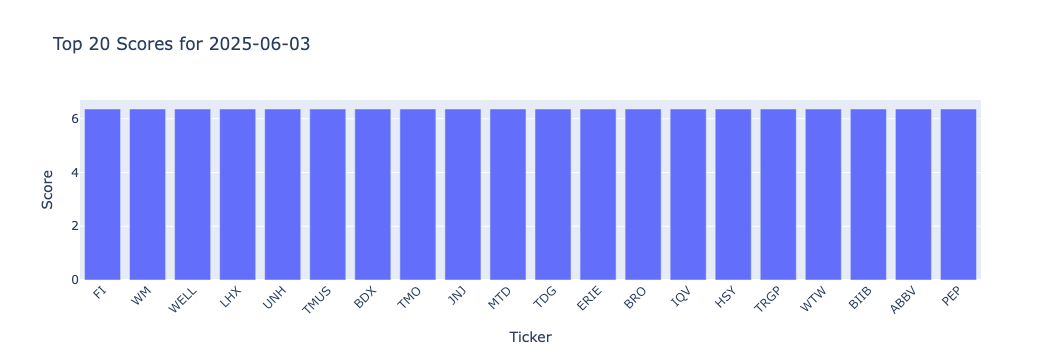

ValueError: value_name (score) cannot match an element in the DataFrame columns.

In [12]:
# Analyze scores for a specific date
scores_df = analyze_model_scores('../model_outputs/technical/2025-06-03')

# View top 10 scores
print(scores_df.head(10))

# Get tickers with scores above a threshold
high_scores = scores_df[scores_df['score'] > 7.0]
print(f"Tickers with scores > 7.0: {len(high_scores)}")
print(high_scores[['ticker', 'score']])

# Analyze score components
if not scores_df.empty and 'details' in scores_df.columns:
    # Get average contribution of each component
    component_means = pd.DataFrame([
        {**{'ticker': row['ticker']}, **row['details']}
        for _, row in scores_df.iterrows()
    ]).mean()
    print("\nAverage contribution of each component:")
    print(component_means)